<a href="https://colab.research.google.com/github/zhaoheng001/colabtogithubdemo/blob/master/lines32_creat_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import functools
import glob
import math
import os
import random

import numpy as np
import tensorflow as tf

In [34]:
def draw_line(angle, height, width, w=2.):
    m = np.zeros((height, width, 1))
    x0 = height*0.5
    y0 = width*0.5
    x1 = x0 + (x0 - 1) * math.cos(-angle)
    y1 = y0 + (y0 - 1) * math.sin(-angle)
    flip = False
    if abs(y0 - y1) < abs(x0 - x1):
        x0, x1, y0, y1 = y0, y1, x0, x1
        flip = True
    if y1 < y0:
        x0, x1, y0, y1 = x1, x0, y1, y0
    x0, x1 = x0 - w / 2, x1 - w / 2
    dx = x1 - x0
    dy = y1 - y0
    ds = dx / dy if dy != 0 else 0
    yi = int(math.ceil(y0)), int(y1)
    points = []
    for y in range(int(y0), int(math.ceil(y1))):
        if y < yi[0]:
            weight = yi[0] - y0
        elif y > yi[1]:
            weight = y1 - yi[1]
        else:
            weight = 1
        xs = x0 + (y - y0 - .5) * ds
        xe = xs + w
        xi = int(math.ceil(xs)), int(xe)
        if xi[0] != xi[1]:
            points.append((y, slice(xi[0], xi[1]), weight))
        if xi[0] != xs:
            points.append((y, int(xs), weight * (xi[0] - xs)))
        if xi[1] != xe:
            points.append((y, xi[1], weight * (xe - xi[1])))
    if flip:
        points = [(x, y, z) for y, x, z in points]
    for y, x, z in points:
        m[y, x] += 2 * z
    m -= 1
    m = m.clip(-1, 1)
    return m

(32, 32, 1)


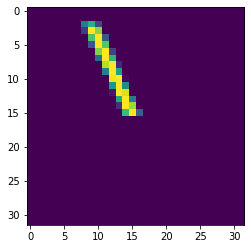

In [35]:
#show one example
x = draw_line(2, 32, 32)
print(x.shape)
x = np.squeeze(x)
x.shape
from matplotlib import pyplot as plt
plt.imshow(x, interpolation='nearest')
plt.show()

In [36]:
def creat_dataset(num_data):
  dataset = np.zeros((num_data,32,32))
  for i in range(num_data):
    angle = 2 * random.random() * math.pi
    m = draw_line(angle, 32, 32)
    m = np.squeeze(m)
    dataset[i] = m
  return dataset
n_dataset = 500
dataset_train = creat_dataset(n_dataset)
print(dataset_train.shape)

(500, 32, 32)


In [37]:
import os
from google.colab import drive
#mount google drive
drive.mount('/content/drive')
path = "/content/lines32/lines32_data500"
os.chdir(path)
os.listdir(path)
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#save 5000 lines image
import imageio
import skimage.io as io
for i in range(n_dataset):
  im = dataset_train[i]
  im = np.array(im)
  imageio.imwrite(np.str(i)+'.jpg',im) #save
  #io.imsave(content/sample_data/lines32+np.str(i)+'.jpg',im)

im = dataset_train[1]
print(im.shape)
im = np.array(im)
#print(im)

#creat grey scale image
#imageio.imwrite('im.jpg', im)


from matplotlib import pyplot as plt
plt.imshow(im, interpolation='nearest')
plt.show()

In [39]:
import time
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch import nn, optim
import torch.nn.functional as F

#from python_utils.import_ import import_global
#import_global('show_array') 
#from python_utils import show_array
#from python_utils import mosaic
#from show_array import *
#from mosaic import *
import sklearn
print(sklearn.__version__)
!apt update -qq
!apt install -qq cmake ffmpeg
#!pip install dlib

![[ ! -e utils ]] && \
  git clone https://github.com/kylemcdonald/python-utils -b show_array utils

0.22.2.post1
60 packages can be upgraded. Run 'apt list --upgradable' to see them.
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 60 not upgraded.
Cloning into 'utils'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 250 (delta 0), reused 0 (delta 0), pack-reused 248
Receiving objects: 100% (250/250), 53.00 KiB | 5.30 MiB/s, done.
Resolving deltas: 100% (140/140), done.
Note: checking out 'a4fd6c2f5275ae6b836f7d01caf42cf46a0af782'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another che

In [42]:
import os
from google.colab import drive
#mount google drive
drive.mount('/content/drive')
path = "/content/lines32"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
print(os.getcwd())

/content/lines32/lines32_data500


In [52]:
#define class Dataset
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torch.optim as optim
import os
import torch.utils.data as data
root ='/content/lines32/'#调用图像
def default_loader(path):
    return Image.open(path).convert('L')
 
class MyTrainData(torch.utils.data.Dataset):
  def __init__(self, txt, transform=None,target_transform=None, loader=default_loader):
    super(MyTrainData,self).__init__()
    fh = open(txt, 'r')
    imgs = []
    for line in fh:
      line = line.strip('\n')
      line = line.rstrip('\n')
      words = line.split()
      imgs.append((words[0]))
    self.imgs = imgs
    self.transform = transform
    self.target_transform = target_transform
    self.loader = loader

  def __getitem__(self, index):
    fn = self.imgs[index]
    img = self.loader(fn)
    if self.transform is not None:
      img = self.transform(img)
    return img

 
  def __len__(self):
    return len(self.imgs) #这个是必须返回的长度

In [49]:
#write txt file for dataset
import os
dir = '/content/lines32/lines32_data500' + '/'
files = os.listdir(dir)
files.sort()
train = open('/content/lines32/train.txt','a')
val = open('/content/lines32/val.txt', 'a')
i = 1
for file in files:
  if i<401:
    fileType = os.path.split(file)
    if fileType[1] == '.txt':
      continue
    name =  str(dir) +  file + '\n'
    train.write(name)
    i = i+1
    print(i)
  else:
    fileType = os.path.split(file)
    if fileType[1] == '.txt':
      continue
    name = str(dir) +file + '\n'
    val.write(name)
    i = i+1
    print(i)
val.close()
train.close()

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [57]:
train_data=MyTrainData(txt=root+'train.txt', transform=transforms.ToTensor())
test_data = MyTrainData(txt=root+'val.txt', transform=transforms.ToTensor())

In [91]:
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True,num_workers=4)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False,num_workers=4)

In [77]:
print('num_of_trainData:', len(train_data))
print('num_of_testData:', len(test_data))

num_of_trainData: 400
num_of_testData: 101


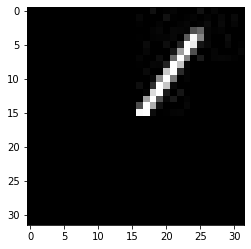

In [66]:
import torchvision
img = torchvision.utils.make_grid(train_data[1]).numpy()
plt.imshow(np.transpose(img,(1,2,0)))
plt.show()

0 torch.Size([64, 1, 32, 32])


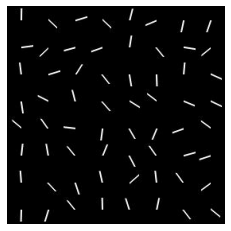

In [97]:
#show one batch
def show_batch(sample_batched):
  images_batch = sample_batched
  batch_size = len(images_batch)
  im_size = images_batch.size(2)
  grid = utils.make_grid(images_batch)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))

 
  
for i_batch, sample_batched in enumerate(test_loader):
  print(i_batch, sample_batched.size())
  if i_batch == 0:
    plt.figure()
    show_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    break
